In [1]:
import warnings
import graphviz
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 패키지 불러오기
from sklearn.linear_model import LinearRegression # sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.feature_selection import RFE # 변수 선택법 (후진 제거법)
from sklearn.preprocessing import scale # 데이터 scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score
# Import ML Classification algos
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram,fcluster
from sklearn.cluster import KMeans,DBSCAN
warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
ds_scale = pd.read_csv("./SCALE불량.CSV",encoding="CP949",engine="python")
ds_scale.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조


# 데이터 결측치 및 Shape확인
- **결측치 없음 확인**
- **720개 input 21개 variable 확인**

In [2]:
print(ds_scale.isnull().sum(axis=0))
print(ds_scale.shape)

PLATE_NO             0
ROLLING_DATE         0
SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64
(720, 21)


# 데이터 Drop
- **PLATE_NO, ROLLING_DATE는 제외해야할 변수이므로 제외했다.**
- **FUR_SZ_TEMP 변수와 FUR_EXTEMP 변수와 동일..**

In [3]:
ds_scale = ds_scale.drop("PLATE_NO",axis=1)
ds_scale = ds_scale.drop("ROLLING_DATE",axis=1)
ds_scale1 = ds_scale

# 데이터 Replace
- **SCALE - 양품 : 1 , 불량 : 0으로 binary변수로 설정**
- **목표변수 SCALE을 따로 분리했다.**

In [4]:
ds_scale["SCALE"].replace(to_replace='양품',value=0,inplace=True)
ds_scale["SCALE"].replace(to_replace='불량',value=1,inplace=True)
#ds_scale["HSB"].replace(to_replace=['적용','미적용'],value=[1,0],inplace=True)

ds_scale_y = ds_scale["SCALE"]
ds_scale_x = ds_scale.drop("SCALE",axis=1,inplace=False)

# 데이터 분리 - 연속형, 범주형
- **연속형 변수의 이상치를 확인해야한다.**
- **범주형과 연속형이 섞여있는 설명변수에서 연속형 변수들만 분리한다**

In [5]:
ds_scale_char = ds_scale_x.select_dtypes(include = "object")
ds_scale_numeric = ds_scale_x.select_dtypes(exclude = "object")

In [6]:
'''
ds_scale = ds_scale["SCALE"].value_counts()
ds_scale.sort_index(inplace = True)
ds_scale.plot.bar()
'''

'\nds_scale = ds_scale["SCALE"].value_counts()\nds_scale.sort_index(inplace = True)\nds_scale.plot.bar()\n'

# 데이터 이상치 유무 확인 - BoxPlot
- **ROLLING_TEMP_T5에 이상치 0을 확인**

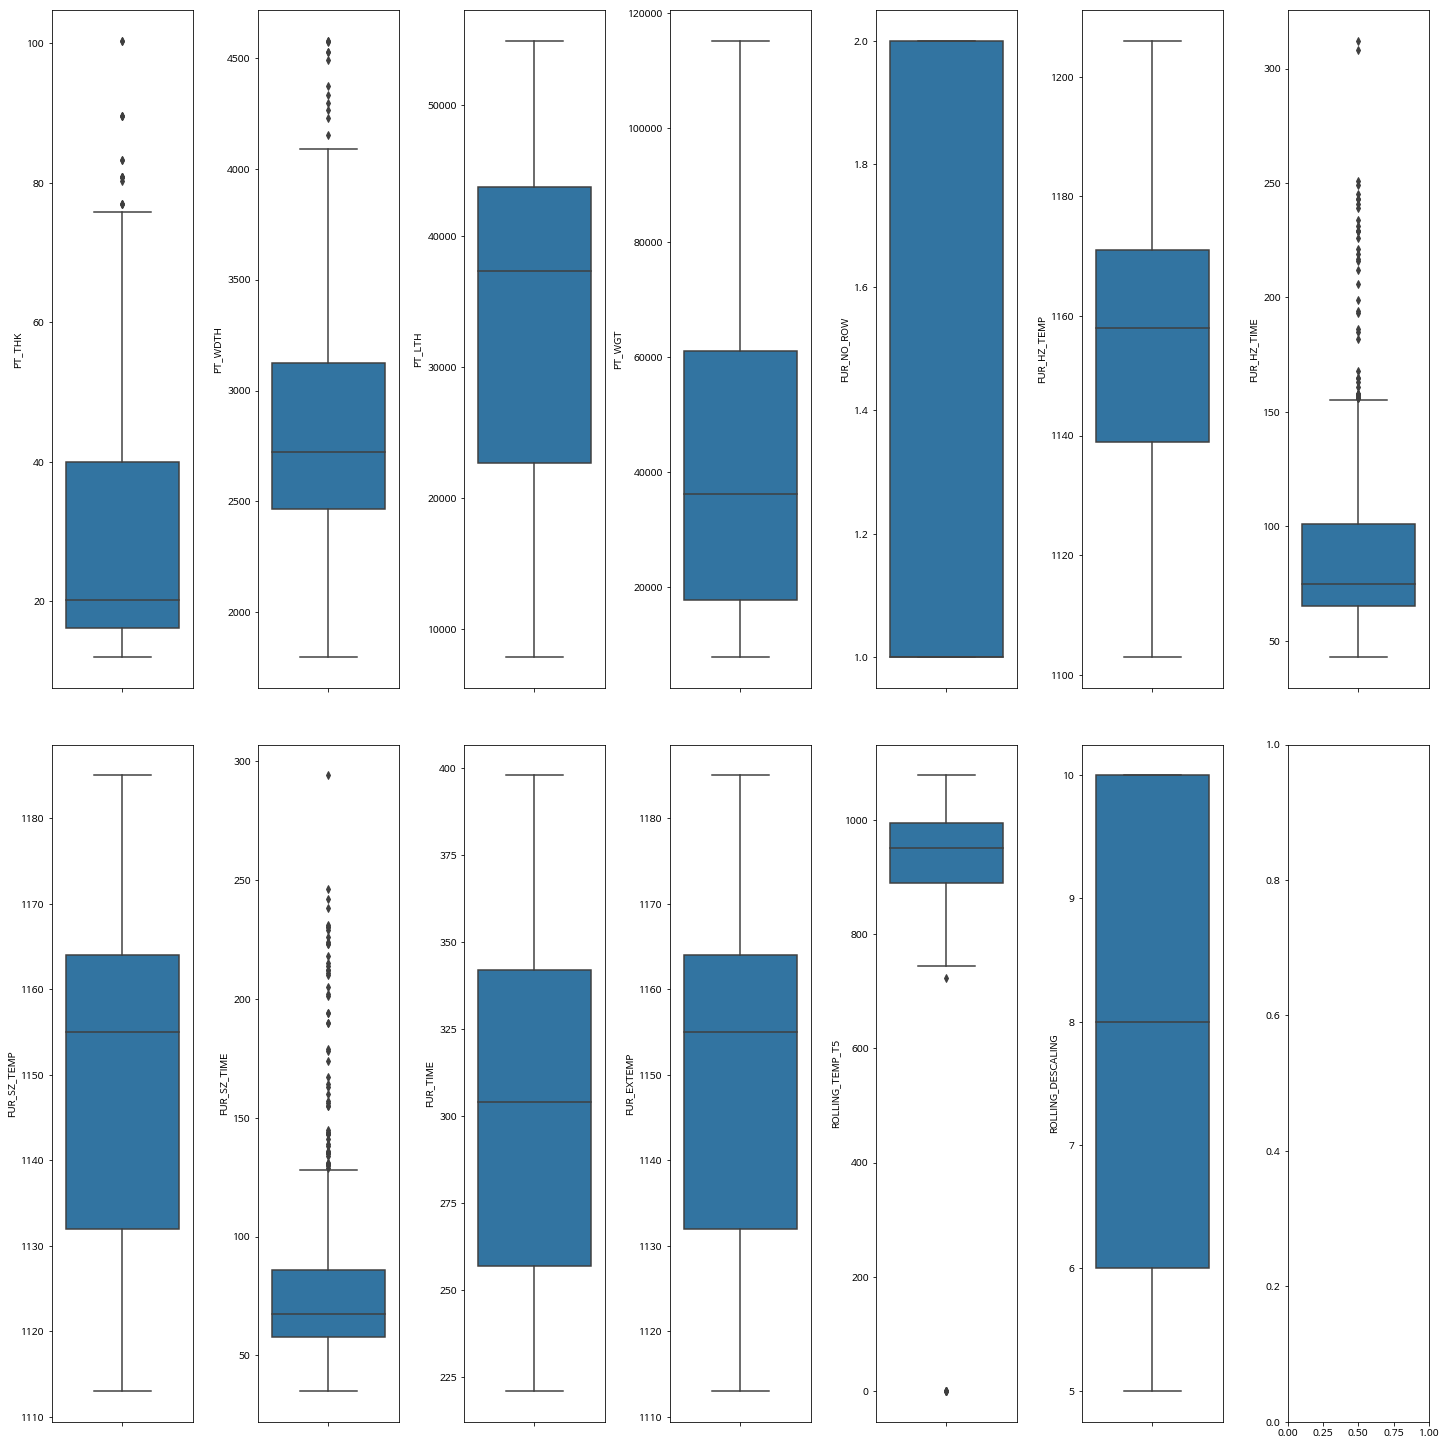

In [7]:
# 이상치 확인
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20,20))
index = 0
axs = axs.flatten()
for k,v in ds_scale_numeric.items():
    sns.boxplot(y=k, data=ds_scale_numeric, ax=axs[index])
    index+=1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

# 데이터 이상치 유무 확인 - Histogram
- **histogram으로 전반적인 설명변수의 분포를 알아봤다.**
- **boxplot과 histogram에서 FUR_NO_ROW 변수에서 특이점을 확인했다. 변수 설명에서 작업 순번으로 되어있다. 시각적으로 확인해보면 이산형 변수였다. 가열로 작업 순번으로 해석했고, 1,2 조건이 서로 다를것이라 결론내려 연속형 변수로 처리했다고 생각한다.**
- **또한 이상치 여부도 확인할 수 있다.**

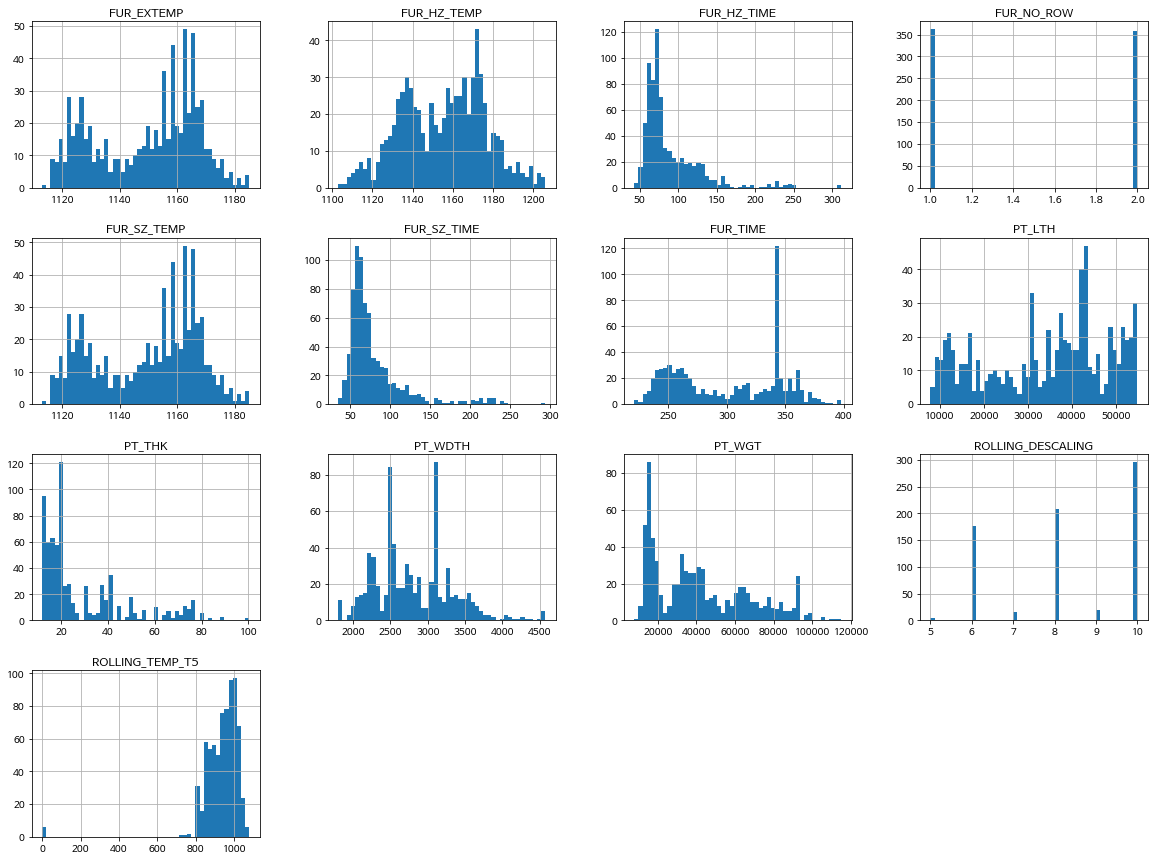

In [8]:
ds_scale_numeric.hist(bins = 50, figsize = (20, 15))
plt.show()

# 데이터 이상치 파악 
- **좀더 자세히 알아보기 위해 각각의 histogram을 그렸다**
- **위의 Boxplot과 비교해봤을 때  FUR_HZ_TIME, FUR_SZ_TIME, PT_THK,ROLLING_TEMP_T5변수에서 이상치가 있을것 같다고 결론내렸다**

'\nplt.hist(ds_scale1[ds_scale1["SCALE"] == 0]["ROLLING_DESCALING"], label = 0, alpha = 0.5)\nplt.hist(ds_scale1[ds_scale1["SCALE"] == 1]["ROLLING_DESCALING"], label = 1, alpha = 0.5)\nplt.legend()\n'

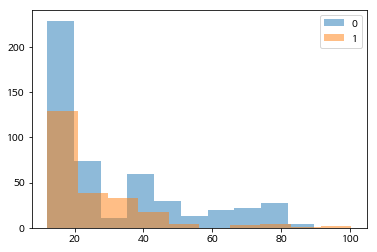

In [9]:
plt.hist(ds_scale1[ds_scale1["SCALE"] == 0]["PT_THK"], label = 0, alpha = 0.5)
plt.hist(ds_scale1[ds_scale1["SCALE"] == 1]["PT_THK"], label = 1, alpha = 0.5)
plt.legend()
# 각각의 주석을 풀고 histogram을 그려서 데이터 파악가능
'''
plt.hist(ds_scale1[ds_scale1["SCALE"] == 0]["PT_WDTH"], label = 0, alpha = 0.5)
plt.hist(ds_scale1[ds_scale1["SCALE"] == 1]["PT_WDTH"], label = 1, alpha = 0.5)
plt.legend()
'''
'''
plt.hist(ds_scale1[ds_scale1["SCALE"] == 0]["PT_WGT"], label = 0, alpha = 0.5)
plt.hist(ds_scale1[ds_scale1["SCALE"] == 1]["PT_WGT"], label = 1, alpha = 0.5)
plt.legend()
'''
'''
plt.hist(ds_scale1[ds_scale1["SCALE"] == 0]["FUR_NO_ROW"], label = 0, alpha = 0.5)
plt.hist(ds_scale1[ds_scale1["SCALE"] == 1]["FUFUR_HZ_TIMER_NO_ROW"], label = 1, alpha = 0.5)
plt.legend()
'''
'''
plt.hist(ds_scale1[ds_scale1["SCALE"] == 0]["FUR_SZ_TEMP"], label = 0, alpha = 0.5)
plt.hist(ds_scale1[ds_scale1["SCALE"] == 1]["FUR_SZ_TEMP"], label = 1, alpha = 0.5)
plt.legend()
'''
'''
plt.hist(ds_scale1[ds_scale1["SCALE"] == 0]["FUR_SZ_TIME"], label = 0, alpha = 0.5)
plt.hist(ds_scale1[ds_scale1["SCALE"] == 1]["FUR_SZ_TIME"], label = 1, alpha = 0.5)
plt.legend()
'''
'''
plt.hist(ds_scale1[ds_scale1["SCALE"] == 0]["FUR_TIME"], label = 0, alpha = 0.5)
plt.hist(ds_scale1[ds_scale1["SCALE"] == 1]["FUR_TIME"], label = 1, alpha = 0.5)
plt.legend()
'''
'''
plt.hist(ds_scale1[ds_scale1["SCALE"] == 0]["ROLLING_TEMP_T5"], label = 0, alpha = 0.5)
plt.hist(ds_scale1[ds_scale1["SCALE"] == 1]["ROLLING_TEMP_T5"], label = 1, alpha = 0.5)
plt.legend()
'''
'''
plt.hist(ds_scale1[ds_scale1["SCALE"] == 0]["ROLLING_DESCALING"], label = 0, alpha = 0.5)
plt.hist(ds_scale1[ds_scale1["SCALE"] == 1]["ROLLING_DESCALING"], label = 1, alpha = 0.5)
plt.legend()
'''

AxesSubplot(0.125,0.125;0.775x0.755)


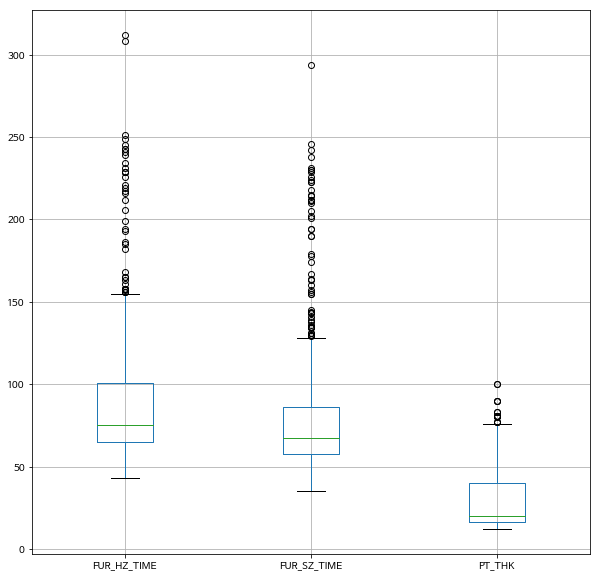

In [10]:
print(ds_scale_numeric.filter(["FUR_HZ_TIME", "FUR_SZ_TIME", "PT_THK"]).boxplot(figsize=(10,10)))

# 이상치 제거
- **이상치로 의심되는 두 변수의 값들을 살펴본결과 압연공정에서의 두께가 상당히 얇았다.**
- **그외 나머지 변수는 대체적으로 비슷했다.**
- **이상치로 판단하기에는 그럴듯한 이유가 있어 보이는 측정치여서 정상값으로 판단하였다.**

In [11]:
print(ds_scale_numeric[ds_scale_numeric["FUR_HZ_TIME"]>300])
print(ds_scale_numeric[ds_scale_numeric["FUR_SZ_TIME"]>250])
ds_scale_numeric.describe()

     PT_THK  PT_WDTH  PT_LTH  PT_WGT  FUR_NO_ROW  FUR_HZ_TEMP  FUR_HZ_TIME  \
548   17.10     2804   51488   58140           1         1142          308   
549   18.11     3122   47067   41780           1         1138          312   

     FUR_SZ_TEMP  FUR_SZ_TIME  FUR_TIME  FUR_EXTEMP  ROLLING_TEMP_T5  \
548         1147           69       342        1147              957   
549         1148           62       342        1148              957   

     ROLLING_DESCALING  
548                 10  
549                 10  
     PT_THK  PT_WDTH  PT_LTH  PT_WGT  FUR_NO_ROW  FUR_HZ_TEMP  FUR_HZ_TIME  \
524   13.06     3405   54170   56730           2         1141           59   

     FUR_SZ_TEMP  FUR_SZ_TIME  FUR_TIME  FUR_EXTEMP  ROLLING_TEMP_T5  \
524         1130          294       342        1130              875   

     ROLLING_DESCALING  
524                 10  


,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,29.267857,2807.127778,34323.269444,41481.777778,1.497222,1155.338889,88.527778,1149.666667,78.802778,300.563889,1149.666667,933.920833,8.319444
std,19.152651,517.839690,13828.434837,24751.322015,0.500340,20.866398,37.660799,17.571788,36.421004,45.390303,17.571788,107.863887,1.623252
min,12.030000,1800.000000,7893.000000,7820.000000,1.000000,1103.000000,43.000000,1113.000000,35.000000,221.000000,1113.000000,0.000000,5.000000
25%,16.090000,2466.000000,22663.000000,17757.500000,1.000000,1139.000000,65.000000,1132.000000,57.750000,257.000000,1132.000000,889.750000,6.000000
50%,20.130000,2725.000000,37380.000000,36120.000000,1.000000,1158.000000,75.000000,1155.000000,67.500000,304.000000,1155.000000,951.000000,8.000000
75%,40.000000,3125.000000,43735.000000,61120.000000,2.000000,1171.000000,101.000000,1164.000000,86.000000,342.000000,1164.000000,994.250000,10.000000
max,100.340000,4575.000000,54917.000000,115080.000000,2.000000,1206.000000,312.000000,1185.000000,294.000000,398.000000,1185.000000,1078.000000,10.000000


# 이상치 제거
- **ROLLING_TEMP_T5변수에서 가열도 온도로 해석되는 설명변수에서 temp 0값은 이상치라고 판단하여 삭제했다.**

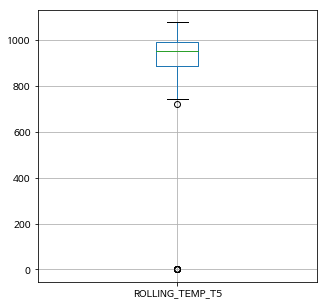

In [12]:
ds_scale.filter(["ROLLING_TEMP_T5"]).boxplot(figsize=(5,5))
ds_scale = ds_scale[ds_scale["ROLLING_TEMP_T5"]>200]

ds_scale_y = ds_scale["SCALE"]
ds_scale_x = ds_scale.drop("SCALE",axis=1)
ds_scale_char= ds_scale_x.select_dtypes(include = "object")
ds_scale_numeric = ds_scale_x.select_dtypes(exclude = "object")

# 범주형 데이터 처리 - dummy

In [13]:
ds_scale_dummy = pd.get_dummies(ds_scale)
ds_scale_dummy.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,...,STEEL_KIND_T8,FUR_NO_1호기,FUR_NO_2호기,FUR_NO_3호기,HSB_미적용,HSB_적용,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,0,32.25,3707,15109,14180,1,1144,116,1133,59,...,0,1,0,0,0,1,0,1,0,0
1,0,32.25,3707,15109,14180,2,1144,122,1135,53,...,0,1,0,0,0,1,0,1,0,0
2,0,33.27,3619,19181,18130,1,1129,116,1121,55,...,1,0,1,0,0,1,0,0,1,0
3,0,33.27,3619,19181,18130,2,1152,125,1127,68,...,1,0,1,0,0,1,0,0,1,0
4,0,38.33,3098,13334,12430,1,1140,134,1128,48,...,1,0,0,1,0,1,1,0,0,0


# 그래프 분석 - pairplot
- **FUR_SZ_TEMP변수와 FUR_EX_TEMP변수를 제외하고는 설명변수에서 선형관계를 파악하지 못했다**
- **그래프 만으로 vital few를 판단하기 보단, Decision Tree를 통해 영향있는 설명변수의 갯수를 줄여 vital few를 찾아야 할것으로 생각된다**

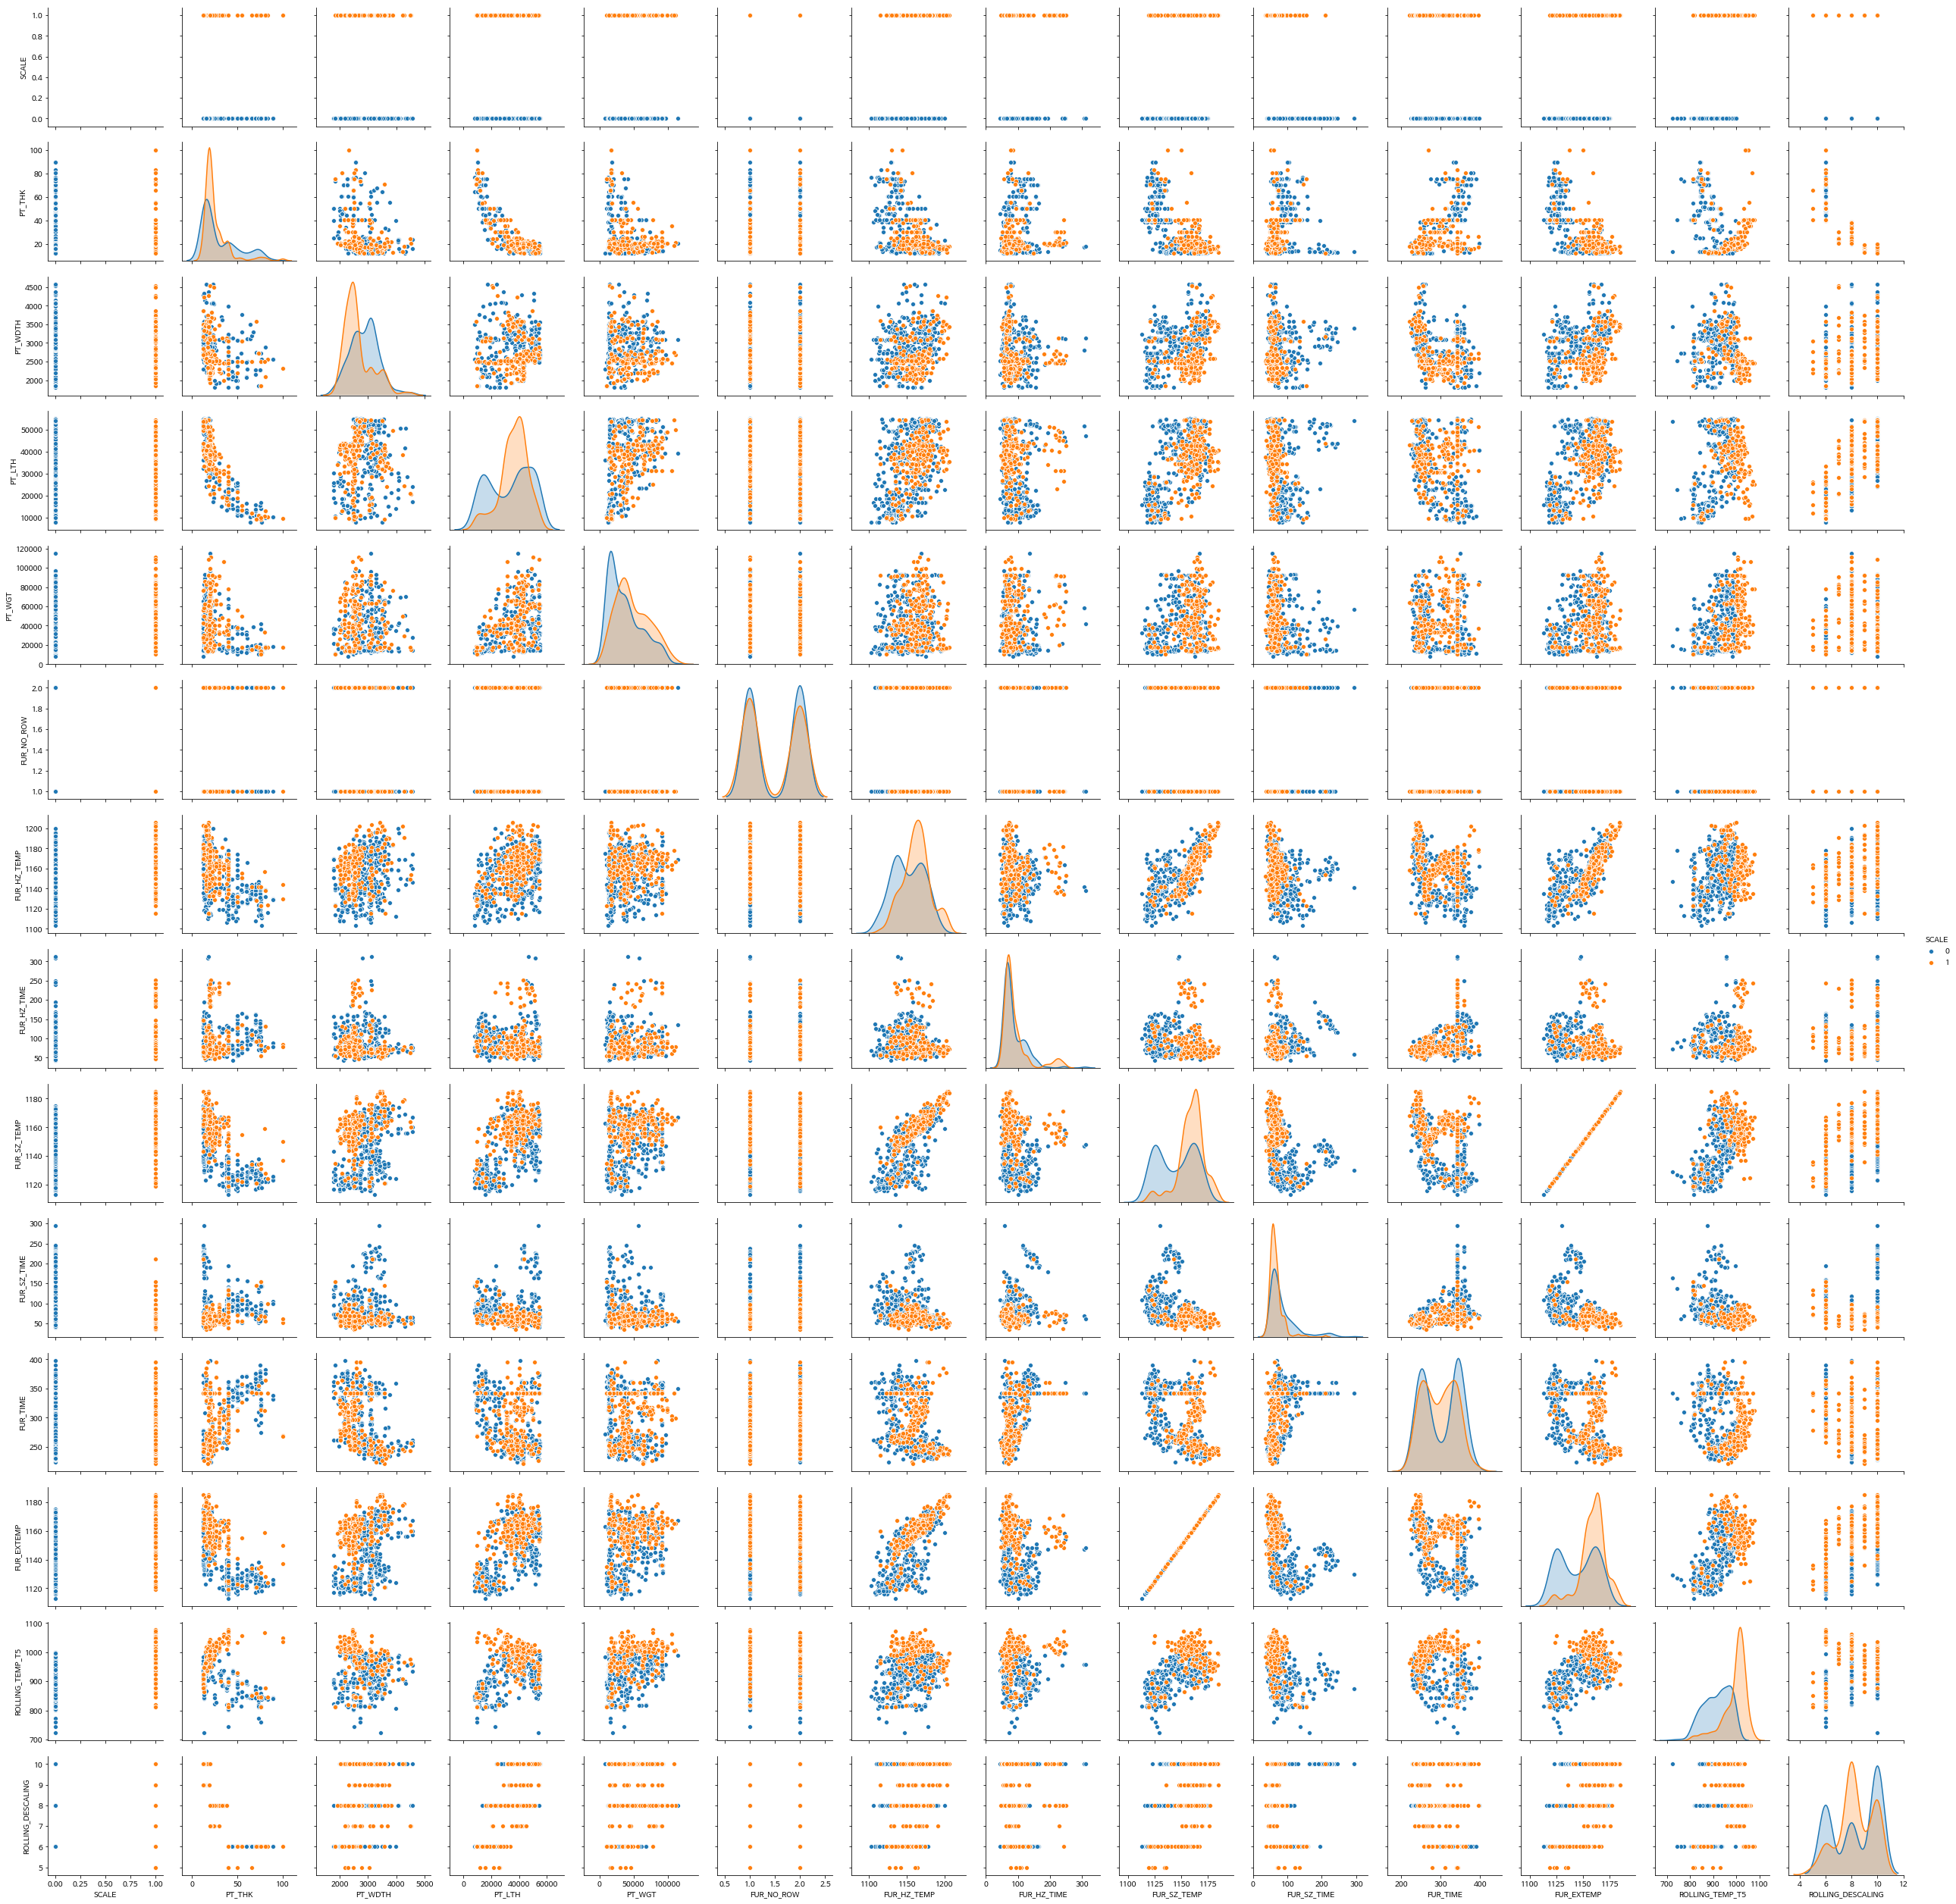

In [14]:
sns.pairplot(ds_scale,hue="SCALE")

# 데이터 분할 (train, test 데이터 7:3)
- Data set을 train과 test로 나누고 초기화한다

In [15]:
ds_scale_y = ds_scale_dummy["SCALE"]
ds_scale_x = ds_scale_dummy.drop("SCALE",axis=1)

train_x , test_x, train_y, test_y = train_test_split(ds_scale_x, ds_scale_y,test_size =0.30, random_state=1)

print("train data X size : ",train_x.shape)
print("train data Y size : ",train_y.shape)
print("test data X size : ",test_x.shape)
print("test data Y size : ",test_y.shape)

train data X size :  (499, 97)
train data Y size :  (499,)
test data X size :  (215, 97)
test data Y size :  (215,)


# 의사결정 나무 (Decision Tree)
- **GridSearchCV 사용**
- **CRiterion: 분리 기준 변경(gini, entropy)**
- **depth는 1~10까지 잡는다. (tree - 최대 깊이)**
- **num_leafs는 1~20까지 잡았다**

In [16]:
depths = np.arange(1, 10)
num_leafs = [1,2,5,7,10,20]
para_criterion = ["gini","entropy"]
param_grid = [{'criterion':para_criterion,'max_depth':depths,'min_samples_leaf':num_leafs}]

tree_GS = DecisionTreeClassifier(random_state = 1)
gs = GridSearchCV(estimator=tree_GS, param_grid=param_grid,cv=10)
gs = gs.fit(train_x, train_y)

print("Train set Accuracy : ",gs.score(train_x,train_y))
print("Test set best Accuracy :",gs.best_score_)
print("Best Decision Tree Parameter :",gs.best_params_)

Train set Accuracy :  0.9959919839679359
Test set best Accuracy : 0.9899799599198397
Best Decision Tree Parameter : {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 5}


# 의사결정 나무 - GridSearch 분석
- **Train set Accuracy :  0.995**
- **Test set best Accuracy : 0.989**
- **Best Decision Tree Parameter : {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 5}**
- **Train과 Test Accuracy를 확인해보면 과적합 된것처럼 보이지만 이를 유념하고 설명변수의 중요도를 확인한다**

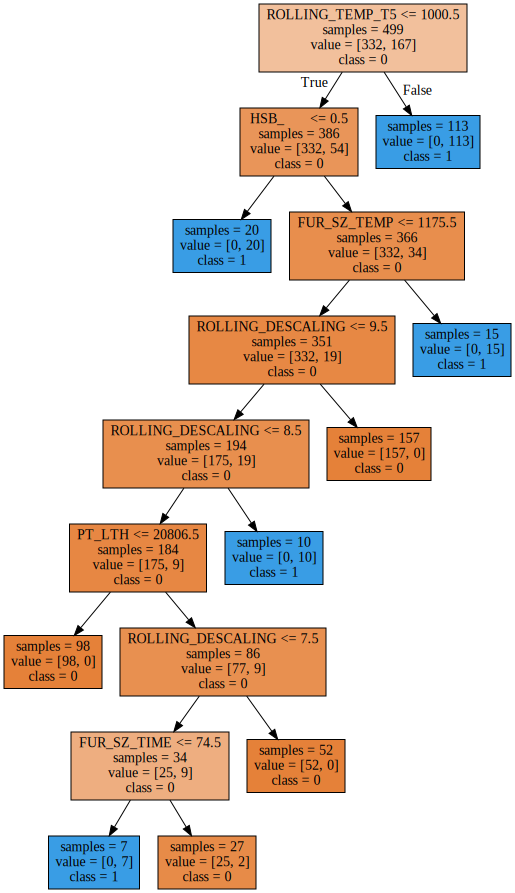

In [17]:
from sklearn.tree import export_graphviz
import graphviz

tree = DecisionTreeClassifier(criterion="entropy",max_depth=8,min_samples_leaf=5, random_state=1234)
tree.fit(train_x, train_y)
export_graphviz(tree, out_file="tree.dot", class_names=["0","1"],
               feature_names=train_x.columns, impurity=False, filled=True)

os.environ["PATH"] += os.pathsep + "C:/Program Files (x86)/Graphviz2.38/bin"

with open("tree.dot",'r', encoding='UTF-8') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 의사결정 트리 (주요인자)
- **트리에서 가장 중요한 변수로 선택한것은 4가지 인자로 다음과 같다. ROLLING_TEMP_T5, ROLLING_DESCALING, HSB_적용, FUR_SZ_TEMP**
- **가열대 온도가 거의 대부분의 불량을 찾아내고 있는 것을 확인했다.**
- **Scale 불량을 발생 증가에 가열대 온도가 가장 중요한 역할을 하는 인자라고 할 수 있다.**
- **나머지 중요도는 0.12~0.15로 의사결정나무에서는 크게 중요하지는 않은것 같다.**
- **가열대 온도 변수와 같은 역할을 할 수 있지만 이미 가열대 온도가 변수를 분리해서 상대적으로 중요도가 떨어져 보일 수 있기 때문에 Decision Tree 이외의 RF와 PCA를 해보기로 했다.**
- **의사결정나무에서는 가장 중요한변수는 가열대 온도이다.**

In [18]:
ds_feature_importance = pd.DataFrame()
ds_feature_importance["Feature"] = train_x.columns
ds_feature_importance["Importance"] = tree.feature_importances_
ds_feature_importance.sort_values("Importance",ascending=False).round(3).head(10)

,Feature,Importance
11,ROLLING_TEMP_T5,0.520
12,ROLLING_DESCALING,0.152
92,HSB_적용,0.139
7,FUR_SZ_TEMP,0.126
8,FUR_SZ_TIME,0.040
2,PT_LTH,0.023
67,SPEC_NV-A,0.000
64,SPEC_NK-KA32,0.000
65,SPEC_NK-KA32-TM,0.000
66,SPEC_NK-KD36-TM,0.000


# 랜덤포레스트 (Random Forest)
- **CRiterion: 분리 기준 변경(gini, entropy)**
- **depth는 1~20까지 잡는다. (tree - 최대 깊이)**
- **n_estimators는 1~10**
- **min_samples_split는 1~20**
- **GridSearchCV.fit 저장**

In [19]:
depths = np.arange(1, 20)
estimator = [i for i in range(1,10)]
feature = ["auto","sqrt","log2"]
para_criterion = ["gini","entropy"]
leaf = [1,2,5,7,10,20]

param_grid = [{'criterion':para_criterion,'max_depth':depths,'min_samples_leaf':leaf,"n_estimators":estimator,\
               "max_features": feature}]

tree_GS = RandomForestClassifier(random_state = 1)
gs = GridSearchCV(estimator=tree_GS, param_grid=param_grid,cv=10)
gs = gs.fit(train_x, train_y)

print("Train set Accuracy : ",gs.score(train_x,train_y))
print("Test set best Accuracy :",gs.best_score_)
print("Best Random Forest Tree Parameter :",gs.best_params_)

Train set Accuracy :  0.9799599198396793
Test set best Accuracy : 0.9599198396793587
Best Random Forest Tree Parameter : {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 9}


# GridSearch 출력
- **GridSearch를 했을 때 가장좋은 test accuracy중 가장 좋은 score를 출력**
- **그 때 조합들의 parameter를 출력했다.**
- **Train과 Test Accuracy를 확인해보면 의사결정트리와 비교했을 때 과적합이 덜 일어났을 거라고 생각했다.**

- **의사결정나무에서의 결과와 동일하게 가열대 온도가 가장 중요한 변수이다.**
- **두번째 변수부터는 의사결정나무에서 예측하지 못한 변수들의 영향력을 확인했다.**

In [20]:
rf_model = RandomForestClassifier(criterion = "entropy", max_depth= 9, min_samples_leaf = 1, \
                                  n_estimators = 9,max_features="log2", random_state= 1)
rf_model.fit(train_x , train_y)

ds_feature_importance = pd.DataFrame()
ds_feature_importance["feature"] = train_x.columns
ds_feature_importance["importance"] = rf_model.feature_importances_
ds_feature_importance.sort_values( by = "importance" , ascending = False)

ds_feature_importance = pd.DataFrame()
ds_feature_importance["Feature"] = train_x.columns
ds_feature_importance["Importance"] = rf_model.feature_importances_
ds_feature_importance.sort_values("Importance",ascending=False).round(3).head(10)

,Feature,Importance
11,ROLLING_TEMP_T5,0.321
10,FUR_EXTEMP,0.095
91,HSB_미적용,0.065
1,PT_WDTH,0.059
5,FUR_HZ_TEMP,0.053
9,FUR_TIME,0.044
12,ROLLING_DESCALING,0.040
92,HSB_적용,0.039
8,FUR_SZ_TIME,0.037
2,PT_LTH,0.036


# 주성분 분석(PCA)

In [21]:

ds_scale_y = ds_scale["SCALE"]
ds_scale_x = ds_scale.drop("SCALE",axis=1)

ds_scale_char= ds_scale_x.select_dtypes(include = "object")
ds_scale_numeric = ds_scale_x.select_dtypes(exclude = "object").columns

list(ds_scale_numeric)
ds_scale_x[ds_scale_numeric] = scale(ds_scale_x[ds_scale_numeric])
print(ds_scale_x.shape)
ds_scale_dummy = pd.get_dummies(ds_scale_x)
print(ds_scale_dummy.shape)

(714, 18)
(714, 97)


# 주성분 분석 실행 - 데이터 표준화

In [22]:
pca = PCA(n_components=97)
cols =[]

x_pca = pca.fit_transform(ds_scale_dummy)

print("PCA Data :\n {}".format(x_pca[:5]))
print("Shape :\n {}".format(x_pca.shape))
ds_x_pca = pd.DataFrame(x_pca, columns=["Prin"+ str(i) for i in range(1,98)])

PCA Data :
 [[ 1.52949130e+00 -1.34300595e+00  4.15291185e-01  1.16018269e+00
  -7.81981201e-01  1.42330686e+00  1.01968549e+00  5.58846739e-01
   9.70518378e-02 -1.00796816e+00  7.09476092e-02 -1.83156347e-01
  -7.44899651e-02  8.02063768e-01 -9.09006020e-01  2.22665803e-01
  -9.95804802e-02  2.62315081e-01  5.48610100e-03  1.45842175e-01
  -1.41686715e-01  2.45406993e-01  2.54198297e-02  5.50931636e-01
   2.11435235e-01  1.01454108e-02 -1.11996363e-01  2.71547364e-01
   3.70870153e-01 -1.83377980e-02  4.42516490e-01 -2.87386489e-01
  -3.11919276e-01  2.50228956e-01 -2.02220188e-01  4.27555763e-03
  -6.06823691e-02 -3.74576084e-02  2.48224818e-02  9.78234217e-03
  -9.09791513e-03  2.59060724e-02 -3.94954192e-02 -1.54070456e-02
   7.86192355e-03 -4.60121728e-02  8.59611848e-02  4.70952048e-02
   8.27466100e-03 -2.74847607e-02  3.77283587e-02  6.76955265e-02
  -6.70175278e-02  2.27368479e-01  1.62646227e-01 -3.48875647e-01
  -2.10003464e-01  9.71671948e-02  1.47158571e-01  3.76078971e-0

# 고유값(Eigenvalue) 확인
- **변수 Variable이 97개가 있기 때문에 Prin을 1~97까지 설정해준다**
- **그래프와 비교해봤을 때 4로 설정했다**
- **1) 4부터 급격하게 변하기 때문에 4이후로는 일정한 변화를 보였기 때문이다**
- **2) EgienValue가 마지막으로 1이상 되는 값이기 때문이다.**

In [23]:
ds_pca = pd.DataFrame()

# 주성분 분석 모델의 주성분 번호, Eigenvalue, Eigenvalue ratio 등을 데이터 프레임의 형태로 저장
ds_pca["Prin"] = [i for i in range(1,98)]
ds_pca["EigenValues"] = pca.explained_variance_ 
ds_pca["EigenValueRatio"] = pca.explained_variance_ratio_
ds_pca["CumsumEigenValueratio"] = np.cumsum(pca.explained_variance_ratio_)
ds_pca.round(3).head(10)

,Prin,EigenValues,EigenValueRatio,CumsumEigenValueratio
0,1,5.809,0.364,0.364
1,2,1.623,0.102,0.466
2,3,1.446,0.091,0.556
3,4,1.014,0.064,0.620
4,5,0.930,0.058,0.678
5,6,0.806,0.050,0.728
6,7,0.600,0.038,0.766
7,8,0.469,0.029,0.795
8,9,0.360,0.023,0.818
9,10,0.342,0.021,0.839


# 고유벡터 (Eigenvector) 확인

In [24]:
ds_feature = pd.DataFrame({"Feature" : ds_scale_dummy.columns})

ds_eigenvectors = pd.concat([ds_feature,pd.DataFrame(pca.components_, columns=["Prin"+ str(i) for i in range(1,98)])], axis = 1)
ds_eigenvectors

,Feature,Prin1,Prin2,Prin3,Prin4,Prin5,Prin6,Prin7,Prin8,Prin9,...,Prin88,Prin89,Prin90,Prin91,Prin92,Prin93,Prin94,Prin95,Prin96,Prin97
0,PT_THK,3.602375e-01,-1.238275e-01,-3.336714e-01,-1.889109e-01,1.612851e-03,-2.972650e-01,9.979964e-02,-0.388609,1.673447e-01,...,0.081682,0.005005,0.003552,-0.008557,-0.001381,0.001381,0.005966,-0.004616,-0.000241,-0.001109
1,PT_WDTH,-1.031981e-01,-3.572788e-01,2.473681e-01,3.298728e-01,-6.393423e-04,-5.319738e-02,5.100795e-01,-0.024327,2.412281e-01,...,-0.080391,0.001018,-0.007353,0.006335,-0.004830,0.004830,0.000020,-0.002370,0.000158,0.002192
2,PT_LTH,-2.693761e-01,4.490337e-01,2.465059e-01,-1.395290e-01,7.860104e-02,-2.368121e-02,3.536190e-02,-0.139860,5.782629e-01,...,-0.007111,0.012569,0.008800,-0.021369,0.006038,-0.006038,0.003007,0.010904,0.000829,-0.014740
3,PT_WGT,-4.508581e-02,1.024210e-01,6.366588e-02,1.503550e-01,-9.601258e-01,-1.276522e-01,3.261126e-03,-0.073204,-3.454380e-02,...,0.012110,-0.007424,0.007009,0.000415,-0.006563,0.006563,0.002117,0.043743,-0.011210,-0.034649
4,FUR_NO_ROW,-1.267984e-01,-4.633151e-02,1.444483e-01,5.627927e-01,2.054018e-01,-5.105950e-01,-4.520905e-01,-0.199620,-3.648537e-02,...,-0.010541,0.009902,0.001162,-0.011063,-0.010163,0.010163,-0.033951,-0.048658,0.059631,0.022977
5,FUR_HZ_TEMP,8.376518e-02,6.421498e-01,-2.022188e-01,3.682475e-01,1.368740e-01,-1.053492e-01,5.240834e-01,0.012286,-2.512450e-01,...,0.047559,-0.054063,0.000533,0.053531,0.002159,-0.002159,-0.041501,0.011938,0.035424,-0.005860
6,FUR_HZ_TIME,-1.610781e-01,-9.883661e-02,1.169739e-01,-4.717242e-01,3.708230e-02,-4.846291e-01,3.118734e-01,-0.134846,-3.353234e-01,...,0.013876,0.014905,0.094429,-0.109334,-0.011889,0.011889,-0.027217,-0.017306,-0.003433,0.047956
7,FUR_SZ_TEMP,1.722446e-02,2.589901e-01,-2.954659e-01,-1.608420e-01,-4.869443e-02,-2.010807e-01,-1.653411e-01,0.071311,4.332113e-01,...,-0.048488,0.037891,0.043867,-0.081758,-0.013953,0.013953,0.075120,-0.027684,0.018106,-0.065542
8,FUR_SZ_TIME,8.087852e-02,1.967718e-01,-9.669905e-02,-2.230305e-02,-1.873351e-02,-6.058275e-02,-2.446344e-01,0.115935,-2.699196e-01,...,0.096847,0.165944,0.284393,-0.450337,0.004049,-0.004049,-0.042910,-0.049497,0.043452,0.048955
9,FUR_TIME,-5.819859e-03,4.322983e-02,6.960587e-02,-6.205631e-02,1.190109e-03,-8.215964e-02,-9.159168e-02,0.042869,-5.467002e-02,...,0.019314,-0.751965,0.434952,0.317013,0.008305,-0.008305,0.232767,-0.142004,-0.043608,-0.047154


# Scree Plot 확인
- **Scree plot 확인 결과, 주성분 4까지 Eigen Value Ratio가 급격히 감소하다가 점점 완만하게 줄어드는 것을 확인할 수 있다. 따라서 주성분 4개를 채택하는 것이 적당할 것으로 판단된다.**
- **고유치가 감소 경향을 시각적으로 펴햐했다. 급격히 감소하는 지점에서 개수를 결정한다**

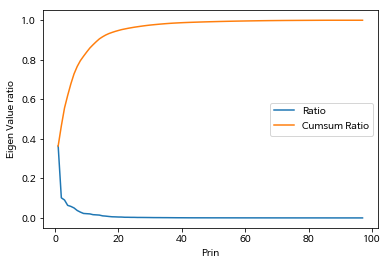

In [25]:
plt.plot(ds_pca["Prin"],ds_pca["EigenValueRatio"], label = "Ratio")

plt.plot(ds_pca["Prin"],ds_pca["CumsumEigenValueratio"], label = "Cumsum Ratio")

plt.ylabel("Eigen Value ratio")
plt.xlabel("Prin")
plt.legend( loc = "best")

# PCA 분석 - eigenvector
- **PCA 분석에서는 이전과는 다른 결과가 나왔다**
- **제품의 규격에서 SPEC_A283-C 이 제품들의 불량률이 높았으며 SPEC_A709-36 이 제품은 그 다음으로 영향력이 높게 나왔다**'
- **의사결정나무나 랜덤포레스트에서는 발견하지 못한 패턴들을 PCA분석을 통해 발견할 수 있었다.**
- **이런 결과가 나온이유는 PCA분석의 경우, 차원이 높아지면 설명력이 급격하게 떨어졌기 때문이라고 생각한다.**

In [26]:
ds_eigenvectors.sort_values(by=["Prin1"],ascending=False)

,Feature,Prin1,Prin2,Prin3,Prin4,Prin5,Prin6,Prin7,Prin8,Prin9,...,Prin88,Prin89,Prin90,Prin91,Prin92,Prin93,Prin94,Prin95,Prin96,Prin97
14,SPEC_A283-C,0.482342,-0.178435,-0.007765,0.114876,-0.007371,-0.301035,0.123176,0.323594,0.278631,...,0.248696,-0.003360,0.069308,-0.065948,0.055068,-0.055068,0.033512,0.042010,-0.095226,0.019704
16,SPEC_A709-36,0.452111,0.094547,0.203478,0.032164,0.000068,0.001872,-0.064301,-0.055027,0.005819,...,-0.402171,-0.020715,0.017828,0.002887,0.151946,-0.151946,-0.011520,0.048410,-0.041674,0.004783
0,PT_THK,0.360238,-0.123828,-0.333671,-0.188911,0.001613,-0.297265,0.099800,-0.388609,0.167345,...,0.081682,0.005005,0.003552,-0.008557,-0.001381,0.001381,0.005966,-0.004616,-0.000241,-0.001109
21,SPEC_AB/EH36-TM,0.206108,0.080275,0.031075,-0.038248,-0.011923,0.045285,0.019732,-0.054447,-0.032272,...,-0.216874,-0.005926,0.007723,-0.001797,-0.063541,0.063541,-0.015622,-0.023675,-0.000598,0.039895
22,SPEC_API-2W-50T,0.192596,-0.018518,-0.024608,0.038069,0.002406,0.092198,-0.018765,-0.099290,-0.104248,...,-0.175492,0.004948,0.000808,-0.005756,-0.048522,0.048522,0.039274,-0.012496,-0.044732,0.017954
18,SPEC_AB/AH32,0.115275,0.069127,0.241691,0.024881,0.012633,0.179756,-0.032531,-0.172177,-0.057335,...,0.260040,0.023603,0.043849,-0.067451,0.508078,-0.508078,-0.008739,0.010237,0.013994,-0.015492
28,SPEC_BV-B,0.108756,0.051029,0.096352,-0.027138,-0.004988,-0.014029,-0.022218,0.038163,-0.003904,...,-0.131420,0.002907,0.018782,-0.021689,-0.017454,0.017454,-0.047655,-0.003958,0.030108,0.021505
10,FUR_EXTEMP,0.108380,0.134439,0.078005,-0.145518,-0.007466,-0.222128,-0.146018,0.100868,-0.158941,...,0.083368,0.079969,-0.602476,0.522507,0.034090,-0.034090,0.088603,-0.021655,0.033864,-0.100812
32,SPEC_COMMON,0.099678,-0.020355,-0.031814,0.015054,0.005603,-0.013893,0.000646,0.010356,-0.003382,...,-0.211730,-0.010547,0.024630,-0.014083,0.009683,-0.009683,-0.015412,0.016736,0.020437,-0.021760
15,SPEC_A516-60,0.092130,-0.086319,-0.414265,0.145814,-0.015201,0.292922,-0.017549,-0.204868,0.044441,...,0.164501,-0.076428,-0.052058,0.128486,-0.022041,0.022041,0.114407,-0.109087,0.009232,-0.014552


# 분석에 필요한 데이터

In [36]:
np.random.seed(seed=1234)
msk = np.random.rand(ds_scale.shape[0],) < 0.7
ds_scale_train = ds_scale[msk]
ds_scale_test = ds_scale[~msk]

print("train data size : {}".format(ds_scale_train.shape))
print("test data size : {}".format(ds_scale_test.shape))

train data size : (489, 19)
test data size : (225, 19)


In [44]:
ds_scale_rem= ds_scale[ds_scale["STEEL_KIND"] != "C1"]
ds_scale_rem.query("STEEL_KIND == 'C1'")

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR


In [45]:
ds_scale_rem_train1= ds_scale_train[ds_scale_train["STEEL_KIND"] != "C1"]
ds_scale_rem_test1= ds_scale_test[ds_scale_test["STEEL_KIND"] != "C1"]
ds_scale_rem_test1

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
3,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1127,885,적용,8,3조
4,0,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1128,873,적용,8,1조
7,0,BV-EH36-TM,T8,38.33,3099,16719,15590,1호기,2,1139,126,1131,52,294,1131,870,적용,8,4조
8,0,BV-EH36-TM,T8,38.33,3099,16719,15590,2호기,1,1127,126,1122,52,293,1122,873,적용,8,1조
9,0,COMMON,T8,38.43,3129,16187,15280,2호기,2,1135,119,1124,73,298,1124,881,적용,8,4조
13,0,COMMON,T0,30.23,1940,34797,16020,1호기,2,1119,130,1120,65,324,1120,926,적용,8,4조
18,0,GL-E32-TM,T1,50.46,2200,21756,37920,1호기,1,1129,122,1125,78,313,1125,925,적용,6,2조
19,0,GL-E32-TM,T1,50.46,2200,21756,37920,2호기,2,1124,54,1127,78,312,1127,928,적용,6,2조
24,0,GL-E36-TM,T8,48.44,2095,24490,39020,1호기,1,1117,69,1120,88,347,1120,832,적용,6,3조
27,0,COMMON,T1,45.40,2150,18453,14140,2호기,2,1132,70,1126,95,344,1126,933,적용,6,1조


In [46]:
# 절편 추가
ds_scale_x_const = sm.add_constant(ds_scale)
ds_scale_x_const.head()

,const,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,1.0,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1133,934,적용,8,2조
1,1.0,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1135,937,적용,8,2조
2,1.0,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1121,889,적용,8,3조
3,1.0,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1127,885,적용,8,3조
4,1.0,0,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1128,873,적용,8,1조


# 회귀분석 실시
- **제품규격(SPEC)과 모든 강종(STELL KIND)을 대입할 경우 log_result.predict에서 C1(강종)이 존재하지 않아 결과가 나타나지 않았다**
- **1)No. Observations(분석 자료 수 : 489)**<br>
  **Df Residuals(잔차 자유도) : 464**<br>
  **Df Model (모델 자유도) : 24**<br>
- **2)설명력 (R-squared) : 0.5343**
- **3) 회귀계수 검정: 유의수준 0.05에서 유의한 변수는 FUR_SZ_TEMP, ROLLING_TEMP_T5, ROLLING_DESCALING이며, 제조 공정이므로 이를 0.01로 낮춘다면 ROLLING_TEMP_T5, ROLLING_DESCALING만이 유의한 변수이다.**

In [47]:
log_model = sm.Logit.from_formula("""SCALE~C(STEEL_KIND)+PT_THK+PT_WDTH+PT_WGT+C(FUR_NO)+FUR_NO_ROW+FUR_HZ_TEMP+FUR_HZ_TIME
+FUR_SZ_TEMP+FUR_SZ_TIME+FUR_TIME+ROLLING_TEMP_T5+HSB+ROLLING_DESCALING+C(WORK_GR)+1""",ds_scale_rem_train1)

log_result = log_model.fit(method='bfgs')
print(log_result.summary())

         Current function value: 0.290857
         Iterations: 35
         Function evaluations: 52
         Gradient evaluations: 41
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  489
Model:                          Logit   Df Residuals:                      464
Method:                           MLE   Df Model:                           24
Date:                Sun, 17 Feb 2019   Pseudo R-squ.:                  0.5343
Time:                        23:41:45   Log-Likelihood:                -142.23
converged:                      False   LL-Null:                       -305.41
                                        LLR p-value:                 7.914e-55
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.3274     27.431     -0.012      

In [49]:
y_pred = log_result.predict(ds_scale_rem_test1)

y_pred_class = (y_pred > 0.5).astype(int)
y_pred_class.head()

3    0
4    0
7    0
8    0
9    0
dtype: int32

# 로지스틱 회귀모델
- **목표변수를 예측한 값은 0.862이다.**
- **실제 목표변수의 값과 test 데이터로부터 예측한 모델 정확도)**

In [51]:
from sklearn import metrics
print("Accruacy : {0:.3f}".format(metrics.accuracy_score(ds_scale_rem_test1["SCALE"], y_pred_class)))

Accruacy : 0.862


# 표준화 회귀 계수
- **SCALE 변수도 함께 scale 처리가 됨**

In [59]:
np.random.seed(seed=1234)
msk = np.random.rand(ds_scale.shape[0],) < 0.7

ds_scale_rem_char= ds_scale.select_dtypes(include = "object")
ds_scale_rem_numeric = ds_scale.select_dtypes(exclude = 'object')

ds_scale_char_train = ds_scale_char[msk]
ds_scale_numeric_scaled_train = scale(ds_scale_rem_numeric[msk])
ds_scale_numeric_scaled_train = pd.DataFrame(ds_scale_numeric_scaled_train,columns=ds_scale_rem_numeric.columns)
ds_scale_numeric_scaled_train.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
0,-0.681228,0.188518,1.781466,-1.441770,-1.132139,-1.002047,-0.542812,0.697464,-0.940114,-0.536911,-0.401517,-0.940114,-0.106107,-0.203343
1,-0.681228,0.188518,1.781466,-1.441770,-1.132139,0.997957,-0.542812,0.853401,-0.826253,-0.702942,-0.379639,-0.826253,-0.060686,-0.203343
2,-0.681228,0.243557,1.609080,-1.142889,-0.971094,-1.002047,-1.262409,0.697464,-1.623283,-0.647598,-0.401517,-1.623283,-0.787427,-0.203343
3,-0.681228,0.516595,0.588477,-1.572053,-1.203488,0.997957,-0.590786,0.983348,-1.224768,-0.592255,0.298610,-1.224768,-1.014534,-0.203343
4,-0.681228,0.516595,0.590436,-1.323597,-1.074652,-1.002047,-0.830651,0.957359,-1.110907,-0.785957,-0.248365,-1.110907,-0.953972,-0.203343


In [60]:
ds_scale_numeric_scaled_train["SCALE"]=np.where(ds_scale_numeric_scaled_train["SCALE"]>0,1,0)
ds_scale_numeric_scaled_train.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
0,0,0.188518,1.781466,-1.441770,-1.132139,-1.002047,-0.542812,0.697464,-0.940114,-0.536911,-0.401517,-0.940114,-0.106107,-0.203343
1,0,0.188518,1.781466,-1.441770,-1.132139,0.997957,-0.542812,0.853401,-0.826253,-0.702942,-0.379639,-0.826253,-0.060686,-0.203343
2,0,0.243557,1.609080,-1.142889,-0.971094,-1.002047,-1.262409,0.697464,-1.623283,-0.647598,-0.401517,-1.623283,-0.787427,-0.203343
3,0,0.516595,0.588477,-1.572053,-1.203488,0.997957,-0.590786,0.983348,-1.224768,-0.592255,0.298610,-1.224768,-1.014534,-0.203343
4,0,0.516595,0.590436,-1.323597,-1.074652,-1.002047,-0.830651,0.957359,-1.110907,-0.785957,-0.248365,-1.110907,-0.953972,-0.203343


In [61]:
ds_scale_scaled_train = pd.concat([ds_scale_numeric_scaled_train, ds_scale_char_train.reset_index(drop=True)],
                               axis=1)

# 로지스틱 회귀분석결과
- **목표 변수의 scaling 을 0과 1로 변환 후 중요도를 측정한 결과 HSB와 강종의 중요도가 높게 측정됨을 알 수 있다.**
- **1) Vital Few = FUR_SZ_TEMP, ROLLING_TEMP_T5, ROLLING_DESCALING**
- **2) 중요도 순서 = HSB, 여러 강종들, ROLLING_DESCALING 순서이다.**

         Current function value: 0.261149
         Iterations: 35


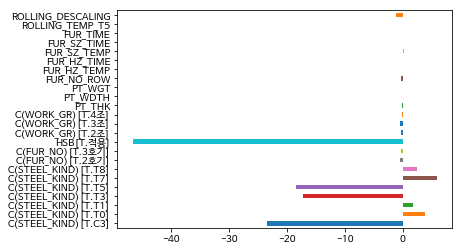

In [62]:
scaled_log_model=sm.Logit.from_formula("""SCALE~C(STEEL_KIND)+PT_THK+PT_WDTH+PT_WGT+C(FUR_NO)+FUR_NO_ROW+FUR_HZ_TEMP+FUR_HZ_TIME
+FUR_SZ_TEMP+FUR_SZ_TIME+FUR_TIME+ROLLING_TEMP_T5+HSB+ROLLING_DESCALING+C(WORK_GR)+1""",ds_scale_rem_train1)

scaled_log_result= scaled_log_model.fit()
ds_log_scaled_coef = pd.DataFrame({"Coef":scaled_log_result.params.values[1:]},
                                 index = scaled_log_model.exog_names[1:])
ds_log_scaled_coef.plot.barh(y="Coef", legend = False)